# Interactive Maps with Python and Folium
## Using data from NYC CitiBike program



In [1]:
import pandas as pd
import folium
from datetime import datetime
# Dependencies and Setup
import numpy as np
from itertools import combinations
# import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, String, Float, Date, Text
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base() 
from flask import Flask, jsonify
import pymongo
import sqlite3
import os
os.environ["PATH"] += os.pathsep + "."
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math as math
from pylab import rcParams

%matplotlib inline

pulled up a map of New York City to add a circle marker.

In [2]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")

folium.CircleMarker(location=[40.7196062, -74.0448274],fill=True).add_to(folium_map)
folium_map

## NYC bike trips - Jersey City
Next, we will load some data. The NYC bike share program makes its data public, it can be downloaded here:
https://www.citibikenyc.com/system-data.

We will use pandas to load the data into python, we’ll convert time strings into DateTime objects
That last line also adds a column to the table indicating the hours of the day. 

In [3]:
from datetime import datetime

bike_data = pd.read_csv("C:/Users/dnunez/Desktop/PersonalFolder/ProfessionalDevelopment/URCodingBootcamp/DataRichmond/Project2/data/JC-201906-citibike-tripdata.csv")
bike_data["starttime"] = pd.to_datetime(bike_data["starttime"])
bike_data["stoptime"] = pd.to_datetime(bike_data["stoptime"])
bike_data["hour"] = bike_data["starttime"].map(lambda x: x.hour)

In [4]:
bike_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,hour
0,316,2019-06-01 00:05:55.721,2019-06-01 00:11:11.994,3187,Warren St,40.721124,-74.038051,3199,Newport Pkwy,40.728745,-74.032108,29677,Subscriber,1993,1,0
1,280,2019-06-01 00:08:09.092,2019-06-01 00:12:50.073,3185,City Hall,40.717733,-74.043845,3267,Morris Canal,40.712419,-74.038526,29571,Subscriber,1984,1,0
2,2162,2019-06-01 00:13:11.880,2019-06-01 00:49:14.364,3199,Newport Pkwy,40.728745,-74.032108,3199,Newport Pkwy,40.728745,-74.032108,26208,Customer,1969,0,0
3,2184,2019-06-01 00:13:30.111,2019-06-01 00:49:54.225,3199,Newport Pkwy,40.728745,-74.032108,3199,Newport Pkwy,40.728745,-74.032108,29487,Customer,1969,0,0
4,139,2019-06-01 00:13:31.852,2019-06-01 00:15:51.788,3207,Oakland Ave,40.737604,-74.052478,3207,Oakland Ave,40.737604,-74.052478,29592,Subscriber,1994,1,0


### Net Arrivals/Departures
We will explore if there is net migration of bikes from one bike station to another and if this migration depends 
on the time of day. We will create a DataFrame containing the locations of each station.

### Pre-processing data
We'll write a function that does the following: 
- generate a DataFrame containing locations of stations
- generates a DataFrame containing the number of trips originating at each station. 
- generates a DataFrame containing the number of trips arriving at each station. 
- join the three dataframes into one.

In [5]:
def get_trip_counts_by_hour(selected_hour):
    # make a DataFrame with locations for each bike station
    locations = bike_data.groupby("start station id").first()
    locations = locations.loc[:, ["start station latitude",
                                 "start station longitude",
                                 "start station name"]]
    
    #select one time of day
    subset = bike_data[bike_data["hour"]==selected_hour]
    
    # count trips for each destination
    departure_counts =  subset.groupby("start station id").count()
    departure_counts = departure_counts.iloc[:,[0]]
    departure_counts.columns= ["Departure Count"]
    
    # count trips for each origin
    arrival_counts =  subset.groupby("start station id").count().iloc[:,[0]]
    arrival_counts.columns= ["Arrival Count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    return trip_counts

# print a sample to check our code works
get_trip_counts_by_hour(6).head()

,Departure Count,start station latitude,start station longitude,start station name,Arrival Count
start station id,,,,,
3184,7,40.714145,-74.033552,Paulus Hook,7
3185,14,40.717733,-74.043845,City Hall,14
3186,42,40.719586,-74.043117,Grove St PATH,42
3187,19,40.721124,-74.038051,Warren St,19
3191,3,40.718211,-74.083639,Union St,3


### Select one hour of the day, and count trips with the same departure point.

Now we'll write a function that generates a new folium map and adds circle markers for each station.

In [6]:
def plot_station_counts(trip_counts):
    # generate a new map
    folium_map = folium.Map(location=[40.738, -73.98],
                            zoom_start=13,
                            tiles="CartoDB dark_matter",
                            width='50%')

    # for each row in the data, add a cicle marker
    for index, row in trip_counts.iterrows():
        # calculate net departures
        net_departures = (row["Departure Count"]-row["Arrival Count"])
        
        # generate the popup message that is shown on click.
        popup_text = "{}<br> total departures: {}<br> total arrivals: {}<br> net departures: {}"
        popup_text = popup_text.format(row["start station name"],
                          row["Arrival Count"],
                          row["Departure Count"],
                          net_departures)
        
        # radius of circles
        radius = net_departures/20
        
        # choose the color of the marker
        if net_departures>0:
            # color="#FFCE00" # orange
            # color="#007849" # green
            color="#E37222" # tangerine
        else:
            # color="#0375B4" # blue
            # color="#FFCE00" # yellow            
            color="#0A8A9F" # teal
        
        # add marker to the map
        folium.CircleMarker(location=(row["start station latitude"],
                                      row["start station longitude"]),
                            radius=radius,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    return folium_map

### Showing Real data
We'll make 2 maps to show the different patterns for bike migration at 9 am and 6pm.

In [7]:
# plot net departures at 9AM

trip_counts = get_trip_counts_by_hour(9)
plot_station_counts(trip_counts)

m = folium.Map(location=[40.7196062, -74.0448274])
m.save('folium.html')

trip_counts = get_trip_counts_by_hour(9)
plot_station_counts(trip_counts)


In [8]:
folium_map.save("net departures at 9AM.html")

In [9]:
# plot net departures at 6PM

trip_counts = get_trip_counts_by_hour(18)
folium_map = plot_station_counts(trip_counts)
folium_map

In [10]:
folium_map.save("net departures at 6PM.html")

In [11]:
df = bike_data
df['Age'] = 2019 - df['birth year'];
df['Age'] = df['Age'].astype(int);
df

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,hour,Age
0,316,2019-06-01 00:05:55.721,2019-06-01 00:11:11.994,3187,Warren St,40.721124,-74.038051,3199,Newport Pkwy,40.728745,-74.032108,29677,Subscriber,1993,1,0,26
1,280,2019-06-01 00:08:09.092,2019-06-01 00:12:50.073,3185,City Hall,40.717733,-74.043845,3267,Morris Canal,40.712419,-74.038526,29571,Subscriber,1984,1,0,35
2,2162,2019-06-01 00:13:11.880,2019-06-01 00:49:14.364,3199,Newport Pkwy,40.728745,-74.032108,3199,Newport Pkwy,40.728745,-74.032108,26208,Customer,1969,0,0,50
3,2184,2019-06-01 00:13:30.111,2019-06-01 00:49:54.225,3199,Newport Pkwy,40.728745,-74.032108,3199,Newport Pkwy,40.728745,-74.032108,29487,Customer,1969,0,0,50
4,139,2019-06-01 00:13:31.852,2019-06-01 00:15:51.788,3207,Oakland Ave,40.737604,-74.052478,3207,Oakland Ave,40.737604,-74.052478,29592,Subscriber,1994,1,0,25
5,203,2019-06-01 00:15:43.259,2019-06-01 00:19:06.745,3203,Hamilton Park,40.727596,-74.044247,3269,Brunswick & 6th,40.726012,-74.050389,26316,Subscriber,1978,1,0,41
6,671,2019-06-01 00:19:41.579,2019-06-01 00:30:52.660,3202,Newport PATH,40.727224,-74.033759,3278,Monmouth and 6th,40.725685,-74.048790,29488,Subscriber,1970,1,0,49
7,271,2019-06-01 00:19:59.603,2019-06-01 00:24:31.177,3270,Jersey & 6th St,40.725289,-74.045572,3186,Grove St PATH,40.719586,-74.043117,26312,Subscriber,1985,1,0,34
8,172,2019-06-01 00:22:26.000,2019-06-01 00:25:18.934,3186,Grove St PATH,40.719586,-74.043117,3279,Dixon Mills,40.721630,-74.049968,29494,Subscriber,1981,1,0,38
9,763,2019-06-01 00:23:00.768,2019-06-01 00:35:44.380,3269,Brunswick & 6th,40.726012,-74.050389,3269,Brunswick & 6th,40.726012,-74.050389,26241,Subscriber,1984,1,0,35


In [12]:
df = bike_data
trips_df = df.groupby(['start station name','end station name']).size().reset_index(name = 'Number of Trips')
trips_df

,start station name,end station name,Number of Trips
0,5 Corners Library,5 Corners Library,11
1,5 Corners Library,Astor Place,2
2,5 Corners Library,Baldwin at Montgomery,2
3,5 Corners Library,Bergen Ave,1
4,5 Corners Library,Brunswick St,1
5,5 Corners Library,Christ Hospital,8
6,5 Corners Library,City Hall,1
7,5 Corners Library,Columbus Drive,2
8,5 Corners Library,Dey St,1
9,5 Corners Library,Glenwood Ave,1


In [13]:
from datetime import datetime

In [14]:
#Ensure data is formatted correctly to avoid errors in the visuals
bike_data['starttime'] = pd.to_datetime(bike_data['starttime'])
bike_data['stoptime'] = pd.to_datetime(bike_data['stoptime'])
bike_data['start station name'] = bike_data['start station name'].astype('category')
bike_data['end station name'] = bike_data['end station name'].astype('category')
bike_data['usertype'] = bike_data['usertype'].astype('category')
bike_data['gender'] = bike_data['gender'].astype('category')
round(df.describe(),2)

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,hour,Age
count,39430.00,39430.00,39430.00,39430.00,39430.00,39430.00,39430.00,39430.00,39430.00,39430.00,39430.00
mean,973.69,3283.31,40.72,-74.05,3277.75,40.72,-74.05,28387.39,1981.32,14.05,37.68
std,12307.82,156.18,0.01,0.01,166.45,0.01,0.01,1700.87,10.11,5.08,10.11
min,61.00,3184.00,40.71,-74.08,195.00,40.70,-74.08,16824.00,1888.00,0.00,16.00
25%,251.00,3194.00,40.72,-74.05,3192.00,40.72,-74.05,26276.00,1975.00,9.00,30.00
50%,389.50,3209.00,40.72,-74.04,3206.00,40.72,-74.04,29275.00,1984.00,15.00,35.00
75%,698.00,3275.00,40.73,-74.04,3275.00,40.73,-74.04,29530.00,1989.00,18.00,44.00
max,1195576.00,3791.00,40.75,-74.03,3791.00,40.81,-73.96,37987.00,2003.00,23.00,131.00


In [15]:
#Quasi Confirm Hypothesis 
df_bikenum = pd.DataFrame()
df_bikenum['First Bike'] = df[df['tripduration'] < 90]['start station name'] 
df_bikenum['Second Bike'] = df[df['tripduration'] < 90]['end station name']
df_bikenum.head(100)

,First Bike,Second Bike
14,Monmouth and 6th,Brunswick & 6th
158,Manila & 1st,Warren St
162,Manila & 1st,Warren St
165,Manila & 1st,Warren St
184,Manila & 1st,Warren St
188,Essex Light Rail,Essex Light Rail
205,City Hall,York St
212,City Hall,York St
220,City Hall,York St
226,City Hall,York St


In [16]:
#Clear up enviornment and drop double count
df_bikenum = pd.DataFrame()
del(df_bikenum)
df = df.drop(df.index[(df['tripduration'] < 90) & 
                          (df['start station latitude'] == df['end station latitude'])])

df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,hour,Age
0,316,2019-06-01 00:05:55.721,2019-06-01 00:11:11.994,3187,Warren St,40.721124,-74.038051,3199,Newport Pkwy,40.728745,-74.032108,29677,Subscriber,1993,1,0,26
1,280,2019-06-01 00:08:09.092,2019-06-01 00:12:50.073,3185,City Hall,40.717733,-74.043845,3267,Morris Canal,40.712419,-74.038526,29571,Subscriber,1984,1,0,35
2,2162,2019-06-01 00:13:11.880,2019-06-01 00:49:14.364,3199,Newport Pkwy,40.728745,-74.032108,3199,Newport Pkwy,40.728745,-74.032108,26208,Customer,1969,0,0,50
3,2184,2019-06-01 00:13:30.111,2019-06-01 00:49:54.225,3199,Newport Pkwy,40.728745,-74.032108,3199,Newport Pkwy,40.728745,-74.032108,29487,Customer,1969,0,0,50
4,139,2019-06-01 00:13:31.852,2019-06-01 00:15:51.788,3207,Oakland Ave,40.737604,-74.052478,3207,Oakland Ave,40.737604,-74.052478,29592,Subscriber,1994,1,0,25


In [17]:
#Data for Top 10 Stations visual
top10 = pd.DataFrame() 
top10['station']= df['start station name'].value_counts().head().index
top10['Number of Starts']= df['start station name'].value_counts().head().values
top10['station'] = top10['station'].cat.remove_unused_categories()
top10['station'] = top10['station'].astype('object')
top10.sort_values(by = 'Number of Starts', ascending = False)

,station,Number of Starts
0,Grove St PATH,4495
1,Hamilton Park,2383
2,Harborside,1829
3,Newport PATH,1780
4,Sip Ave,1737


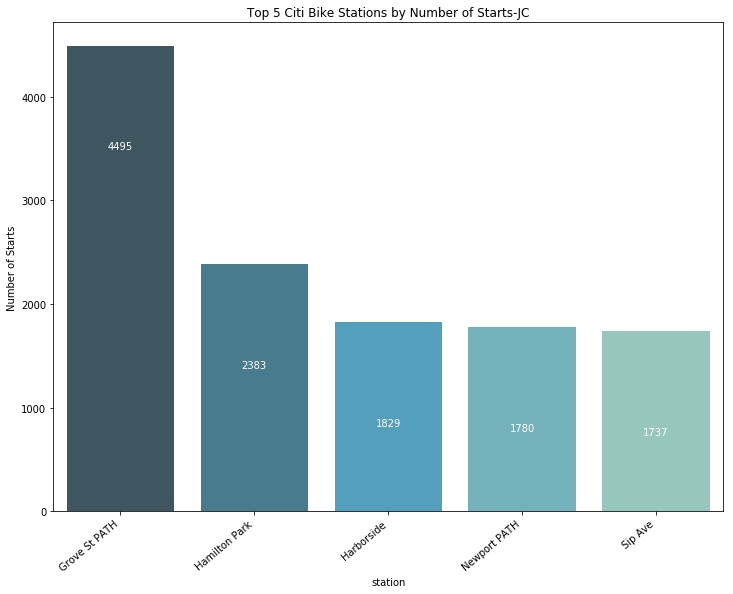

<Figure size 864x648 with 0 Axes>

In [27]:
#Plot for Part 1: Top 5 Stations
ax = sns.barplot('station', 'Number of Starts', data = top10, palette="GnBu_d")
ax.set_title('Top 5 Citi Bike Stations by Number of Starts-JC', fontsize = 12)
rcParams['figure.figsize'] = 12,9
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha = 'right')
for index, row in top10.iterrows():
    ax.text(index,row['Number of Starts']-1000,row['Number of Starts'], 
            color='white', ha="center", fontsize = 10)
plt.show()

plt.savefig("img/topfivestations.png", bbox_inches="tight", transparent=True)

In [19]:
top_stations_df = df.groupby(['start station id']).size().reset_index(name = 'Number of Stations');
top_stations_df = top_stations_df.sort_values('Number of Stations', ascending = False);
top_stations_df

,start station id,Number of Stations
2,3186,4495
14,3203,2383
43,3639,1829
13,3202,1780
8,3195,1737
33,3276,1472
0,3184,1398
11,3199,1273
20,3211,1118
1,3185,1098


In [20]:
#Identify the 10 most popular trips
trips_df = pd.DataFrame()
trips_df = df.groupby(['start station name','end station name']).size().reset_index(name = 'Number of Trips')
trips_df = trips_df.sort_values('Number of Trips', ascending = False)
trips_df["start station name"] = trips_df["start station name"].astype(str)
trips_df["end station name"] = trips_df["end station name"].astype(str)
trips_df["Trips"] = trips_df["start station name"] + " to " + trips_df["end station name"]
trips_df = trips_df[:10]
trips_df = trips_df.drop(['start station name', "end station name"], axis = 1)
trips_df = trips_df.reset_index()
trips_df.head()

,index,Number of Trips,Trips
0,651,826,Hamilton Park to Grove St PATH
1,606,564,Grove St PATH to Hamilton Park
2,622,442,Grove St PATH to Marin Light Rail
3,1215,441,Marin Light Rail to Grove St PATH
4,161,391,Brunswick & 6th to Grove St PATH


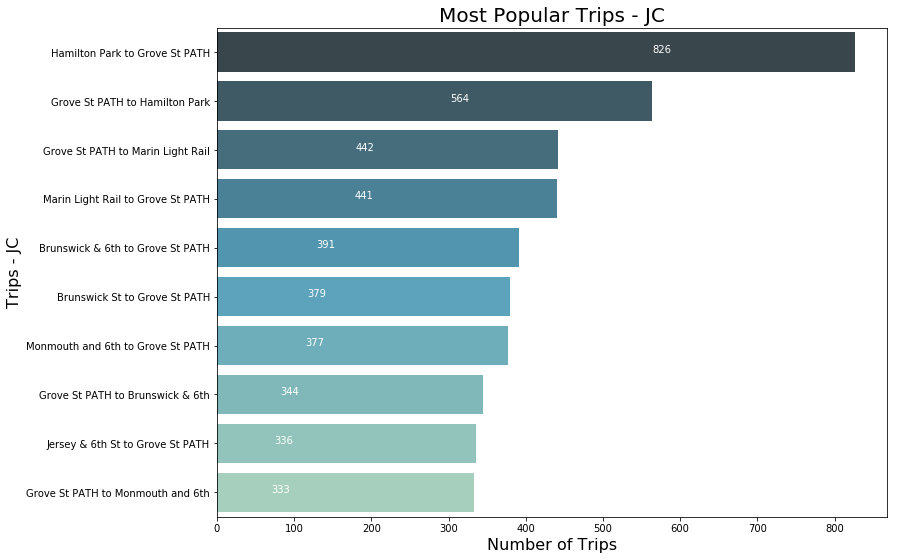

<Figure size 864x648 with 0 Axes>

In [25]:
ax4 = sns.barplot('Number of Trips','Trips', data = trips_df,palette="GnBu_d")
ax4.set_title('Most Popular Trips - JC', fontsize = 20)
ax4.set_ylabel("Trips - JC",fontsize=16)
ax4.set_xlabel("Number of Trips",fontsize=16)
for index, row in trips_df.iterrows():
    ax4.text(row['Number of Trips']-250,index,row['Number of Trips'], 
             color='white', ha="center",fontsize = 10)
plt.show()

plt.savefig("populartrips.png", bbox_inches="tight", transparent=True)

### Busiest Bike by Times and Minutes Used

Busiest bike and count can be identified by a groupby function
Function above will also identify the number of times the bike was used
A similar groupby function which calls for the sum on minutes can identify the number of minutes the bike was used.

In [22]:
bike_use_df = df.groupby(['bikeid']).size().reset_index(name = 'Number of Bikes');
bike_use_df = bike_use_df.sort_values('Number of Bikes', ascending = False);
bike_use_df

,bikeid,Number of Bikes
294,29453,160
395,29572,155
437,29618,145
454,29642,143
179,29203,142
256,29287,138
90,26240,137
440,29621,136
434,29615,135
183,29207,133


In [23]:
#Bike usage based on number of times used
bike_use_df = pd.DataFrame()
bike_use_df = df.groupby(['bikeid']).size().reset_index(name = 'Number of Times Used')
bike_use_df = bike_use_df.sort_values('Number of Times Used', ascending = False)

bike_use_df = bike_use_df[:10]
bike_use_df['bikeid'] = bike_use_df['bikeid'].astype(str)
bike_use_df['bikeid'] = ('Bike ' + bike_use_df['bikeid'])
bike_use_df = bike_use_df.reset_index()
bike_use_df.head()

,index,bikeid,Number of Times Used
0,294,Bike 29453,160
1,395,Bike 29572,155
2,437,Bike 29618,145
3,454,Bike 29642,143
4,179,Bike 29203,142


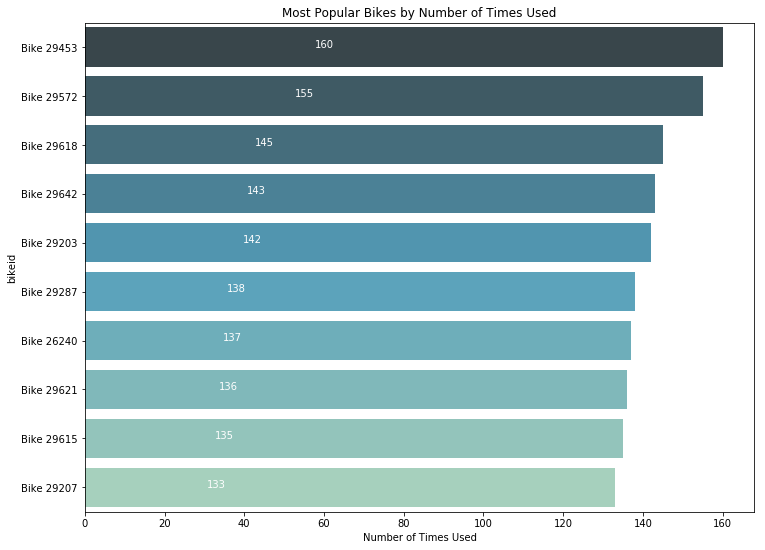

In [24]:
#Visual of most used bike based on Number of Trips
ax8 = sns.barplot('Number of Times Used', 'bikeid',data = bike_use_df, palette="GnBu_d")
ax8.set_title('Most Popular Bikes by Number of Times Used')
for index, row in bike_use_df.iterrows():
    ax8.text(row['Number of Times Used']-100,index,row['Number of Times Used'], color='white', ha="center", fontsize =10)
plt.show()